### Добро пожаловать в царство велосипедов, костылей, велосипедов из костылей и инвалидных колясок :)

Я уверен, что всё, что здесь есть, можно улучшить и сделать проще как минимум в 2 раза.

Но я как обычно сильно увлёкся (захватывающе же это всё, согласитесь?) и посему вновь вбегаю в уходящие двери закрывающегося поезда с тем, что есть.

Внизу документа приложу свои личные выводы, своего рода самофидбэк.

# Predict TripAdvisor Rating

## Import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import datetime as dt
import math as m

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# удаляем из ячейки спецсимволы
def cleanstr(x, y):
    def strremove(x):
        if type(x) == str:
            mtb = x.maketrans('', '', y)
            res = x.translate(mtb)
            return res
    df[x] = df[x].apply(strremove)
    return

## Data

In [5]:
DATA_DIR = 'kaggle/'
df_train = pd.read_csv(DATA_DIR+'main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [6]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      50000 non-null  object 
 1   city               50000 non-null  object 
 2   cuisine_style      38410 non-null  object 
 3   ranking            50000 non-null  float64
 4   price_range        32639 non-null  object 
 5   number_of_reviews  46800 non-null  float64
 6   reviews            49998 non-null  object 
 7   url_ta             50000 non-null  object 
 8   id_ta              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [8]:
df.sample(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating
20117,id_1106,London,"['Italian', 'Cafe', 'European', 'British', 'Ve...",1108.0,$,430.0,"[['Cute place + good food', 'Try their full br...",/Restaurant_Review-g186338-d1881282-Reviews-Ca...,d1881282,1,4.5
35080,id_1390,Warsaw,NaN,1392.0,NaN,21.0,"[['Refreshing', 'Tasty vegeterian dishes in a ...",/Restaurant_Review-g274856-d9567816-Reviews-Li...,d9567816,1,3.5
3929,id_3929,Barcelona,"['Italian', 'Vegetarian Friendly']",2969.0,$$ - $$$,18.0,"[['Good pizza and friendly staff', 'Authentic ...",/Restaurant_Review-g187497-d12500855-Reviews-B...,d12500855,0,0.0
23281,id_11171,London,"['Middle Eastern', 'Lebanese', 'Fast Food', 'M...",11181.0,$,67.0,"[['Not really sure about that place', 'Good fo...",/Restaurant_Review-g186338-d3253024-Reviews-Hu...,d3253024,1,3.5
16616,id_2147,Stockholm,NaN,2150.0,NaN,9.0,"[['A good service', 'Correct'], ['06/25/2017',...",/Restaurant_Review-g189852-d5599486-Reviews-Co...,d5599486,1,2.5


## Предварительная обработка
Разбираю строки и списки на легкоусвояемые цифры

### City

In [9]:
# создаём столбец с "популярностью" городов, 1 - чаще всего в датасете
def city_pop():
    df['city_num'] = np.nan
    pop = pd.DataFrame(df.city.value_counts()).reset_index()
    pop.columns = ['city', 'pop']
    pop['pop'] = [i for i in range(1, len(pop)+1)]
    for x in pop.city:
        df.loc[df[df.city == x].index.tolist(), 'city_num'] = pop[pop['city'] == x]['pop'].item()
    return


city_pop()

За кадром я пересобрал CSV на основе Евростата. Пришлось сделать много ручных операций поэтому сборку сюда не включаю.

Вероятно можно было бы порыться активнее и найти дополнительные данные, которые помогли бы автоматизировать, например переводы названий на английский (с языка страны), но уже откровенно зарылся и ослеп.

Проверял данные по одинокоживущим людям, общей численности населения, студентам и экономически активным людям, корреляция между всеми этими признаками колебалась от 97% до 99% и я оставил только общую численность, чтоб не засорять.

Дополнительно добавил среднюю ЗП по стране и среднюю, хм, состоятельность, как я её понял.

In [10]:
wage = pd.read_csv('eurostat_wage_2.csv')
df = pd.merge(df, wage, on='city', how='left')

### Cuisine

In [11]:
# чистим ячейки от спецсимволов
cleanstr('cuisine_style', "'[] ")

# создаём value counts всех кухонь
df_cuisine = pd.DataFrame(df.cuisine_style)
df_cuisine.cuisine_style = df_cuisine.cuisine_style.apply(
    lambda x: x.split(',') if type(x) == str else x)
df_cuisine = df_cuisine.explode(column='cuisine_style')
df_cuisine = pd.DataFrame(
    df_cuisine.cuisine_style.value_counts()).reset_index()
df_cuisine.columns = ['cuisine', 'count']
# и список на его основе
df_cuisine_list = pd.DataFrame(df_cuisine.loc[:, 'cuisine'])

# считаем количество кухонь по ресторану
df['cuisine_style'] = df.cuisine_style.apply(
    lambda x: x.split(',') if type(x) == str else x)
df['cuisines_count'] = df.cuisine_style.apply(
    lambda x: len(x) if bool(x) == True else np.nan)

# проворачиваем такую же штуку с популярностями, 1 - чаще всего


def cui_pop():
    pop = df_cuisine
    pop.columns = ['cuisine', 'pop']
    pop['pop'] = [i for i in range(1, len(pop)+1)]
    df_temp = pd.DataFrame(df.cuisine_style)
    df_temp.cuisine_style[df_temp.cuisine_style.isna() == True] = ['0']
    df_temp = pd.DataFrame(df_temp['cuisine_style'].tolist())
    for x in pop.cuisine:
        for i in df_temp.columns:
            df_temp[i][df_temp[i] == x] = pop[pop['cuisine'] == x]['pop'].item()
    df_temp['cui_pop'] = df_temp.apply(
        lambda x: ",".join(x.astype(str)), axis=1)
    df_temp = pd.DataFrame(df_temp.loc[:, 'cui_pop'])
    return df_temp

# переводим числа внутри списка во float


def listtofloat(x):
    temp = []
    for item in x:
        item = float(item)
        temp.append(item)
    return temp


# костыль: прочищаем грязный псевдосписок cui_pop, бьём его, чистим от пустот, и очисляем
df['cui_pop'] = cui_pop()
cleanstr('cui_pop', 'None')
df.cui_pop = df.cui_pop.apply(lambda x: x.split(','))
df.cui_pop = df.cui_pop.apply(lambda x: list(filter(None, x)))
df.cui_pop = df.cui_pop.apply(listtofloat)

# на основе этого списка получаем самую популярную и самую непопулярную кухни внутри реста, и пару средних
df['cui_maxpop'] = df.cui_pop.apply(lambda x: min(x))
df['cui_meanpop'] = df.cui_pop.apply(lambda x: round(np.mean(x)))
df['cui_medpop'] = df.cui_pop.apply(lambda x: np.median(x))
df['cui_minpop'] = df.cui_pop.apply(lambda x: max(x))

# возвращаем NaN по нулю, с ним пока проще
df.loc[df[df.cui_maxpop == 0].index.tolist(), 'cui_maxpop'] = np.nan
df.loc[df[df.cui_meanpop == 0].index.tolist(), 'cui_meanpop'] = np.nan
df.loc[df[df.cui_medpop == 0].index.tolist(), 'cui_medpop'] = np.nan
df.loc[df[df.cui_minpop == 0].index.tolist(), 'cui_minpop'] = np.nan

### Price

In [12]:
# по-простому перебиваем прайс в числа
df.loc[df[df.price_range == '$'].index.tolist(), 'price_range'] = 1.0
df.loc[df[df.price_range == '$$ - $$$'].index.tolist(), 'price_range'] = 2.0
df.loc[df[df.price_range == '$$$$'].index.tolist(), 'price_range'] = 3.0
df.price_range = pd.to_numeric(df.price_range, downcast='float')

df.loc[df[df.price_range == 0.0].index.tolist(), 'price_range'] = np.nan

### Reviews

In [13]:
# чистим строку от спецсимволов и дробим её
cleanstr('reviews', "'[] ")
df.reviews = df.reviews.apply(lambda x: x.split(',') if bool(x) == True else x)

date_re = '\d{1,4}([.\-/])\d{1,2}([.\-/])\d{1,4}'


# создаём столбец с текстом отзывов
def rev_str(x):
    rev = []
    if bool(x) == True:
        for item in x:
            if re.match(date_re, item) == None:
                rev.append(item)
    return rev


# создаем столбец с датой отзывов
def rev_date(x):
    date = []
    if bool(x) == True:
        for item in x:
            if re.match(date_re, item) != None:
                item = dt.datetime.strptime(item, '%m/%d/%Y')
                date.append(item)
    return date


# по-простому переводим отзыв в его длину
df['rev_str'] = df.reviews.apply(rev_str)
df.rev_str = df.rev_str.apply(str)
cleanstr('rev_str', "'[] ,")
df.rev_str = df.rev_str.apply(len)
df.loc[df[df.rev_str == 0].index.tolist(), 'rev_str'] = np.nan

# разбиваем даты на более раннюю и более позднюю
df['rev_date'] = df.reviews.apply(rev_date)
df['rev_min'] = df.rev_date.apply(
    lambda x: min(x) if bool(x) == True else np.nan)
df['rev_max'] = df.rev_date.apply(
    lambda x: max(x) if bool(x) == True else np.nan)

# берём дельту между ними и переводим всё в дни
df['rev_delta'] = df.rev_max - df.rev_min
df.rev_max = df.rev_max - df.rev_min.min()
df.rev_min = df.rev_min - df.rev_min.min()

# переводим дни во float
df.rev_min = df.rev_min.apply(lambda x: x.days)
df.rev_max = df.rev_max.apply(lambda x: x.days)
df.rev_delta = df.rev_delta.apply(lambda x: x.days)

## Drop вспомогательных столбцов

In [14]:
df.drop('cui_pop', axis=1, inplace=True)
df.drop('rev_date', axis=1, inplace=True)

## Обработка NaN 

In [15]:
# столбцы isnull отмечающие наличие пропусков в данных
df_isnull = pd.DataFrame(df.isnull().any()).reset_index()
df_isnull.columns = ['column', 'TF']
df_isnull = df_isnull[df_isnull['TF'] == True]
for item in df_isnull.column:
    df[item+'_isnan'] = pd.isna(df[item]).astype('uint8')

## Создаём Dummies

In [16]:
# создаём dummies по городам
df = pd.get_dummies(df, columns=['city'], dummy_na=True)

# создаём dummies по кухням используя костыль, так как я не придумал, как прикрутить библиотечные к спискам
df_cuisines = pd.DataFrame(df.cuisine_style)
for cuisine in df_cuisine_list.cuisine:
    df_cuisines[cuisine] = np.nan
for cuisine in df_cuisine_list.cuisine:
    df_cuisines.loc[df_cuisines[df_cuisines.cuisine_style.str.contains(cuisine) == True].index.tolist(),cuisine] = 1
df_cuisines = df_cuisines.fillna(0)
df_cuisines.drop('cuisine_style', axis=1, inplace=True)
df = df.merge(df_cuisines, how='outer', left_index=True, right_index=True)

## Drop object'ов

In [17]:
for col in df.columns:
    if df[col].dtype == 'object':
        df.drop(col, axis=1, inplace=True)

## Заполнение NaN медианным по городу

In [18]:
def fillna_median_by_city():
    for city in df['city_num'].value_counts().index:
        temp = df.loc[df[df['city_num'] == city].index.tolist()]
        nan_indicator = pd.DataFrame(temp.isnull().any()).reset_index()
        nan_indicator = nan_indicator[nan_indicator[0] == True]['index'].tolist()
        for col in temp.columns:
            if col in nan_indicator:
                temp[col].fillna(temp[col].median(), inplace=True)
        df.loc[df[df['city_num'] == city].index.tolist()] = temp
    return

fillna_median_by_city()

## EDA 

Разведку я толком не провёл. Таков мой грех.

Я попробовал прикрутить то, что изобрёл в прошлый раз, и закономерно второй раз оно не сработало.

In [19]:
filter_col = ['ranking', 'price_range', 'number_of_reviews', 'rating', 'city_num', 'total_pop', 'wage', 'wealth_per_adult',
              'cuisines_count', 'cui_maxpop', 'cui_meanpop', 'cui_medpop', 'cui_minpop', 'rev_str', 'rev_min', 'rev_max', 'rev_delta']
df_filtered = df.loc[df[df['rating'] != 0].index.tolist(), filter_col]

In [20]:
# Построитель графиков на весь датафрейм
def firstlook(df):
    stcol = df.columns.tolist()  # список столбцов
    columns = 2  # удобное число столбцов
    rows = m.ceil(len(stcol)/columns)  # расчитываем число строк
    cou = 0  # счётчик для графиков

    # создаём поле с сабплотами
    fig, axes = plt.subplots(rows, columns, figsize=(12, rows*1.5))
    plt.subplots_adjust(top=4)

    for col in stcol:  # перебираем столбцы датафрейма
        # список по отдельным значениям столбца
        names = pd.DataFrame(df[col].value_counts()).index.tolist()
        # костыль: я принял, что у нас вряд ли есть больше 10 качеств в столбце
        if len(names) <= 10:
            for name in names:  # перебираем их
                # фильтруем по значению
                subset = df[df[col] == name]
                # рисуем денсити-плот по score из нашего фильтра
                sns.distplot(subset['rating'], hist=True, kde=False,
                             hist_kws={'linewidth': 3},
                             label=name, ax=axes[cou // columns][cou % columns])
            # применяем название к сабплоту
            axes[cou // columns, cou % columns].set_title(col)
        elif len(names) > 10:
            # рисум одиночный денсити-плот по столбцу
            sns.distplot(df[col], hist=True, kde=False,
                         hist_kws={'linewidth': 3},
                         label=col, ax=axes[cou // columns][cou % columns])
            # применяем название к сабплоту
            axes[cou // columns, cou % columns].set_title(col)
        # увеличиваем счётчик, чтобы отрисовать следующий сабплот
        cou += 1
    return

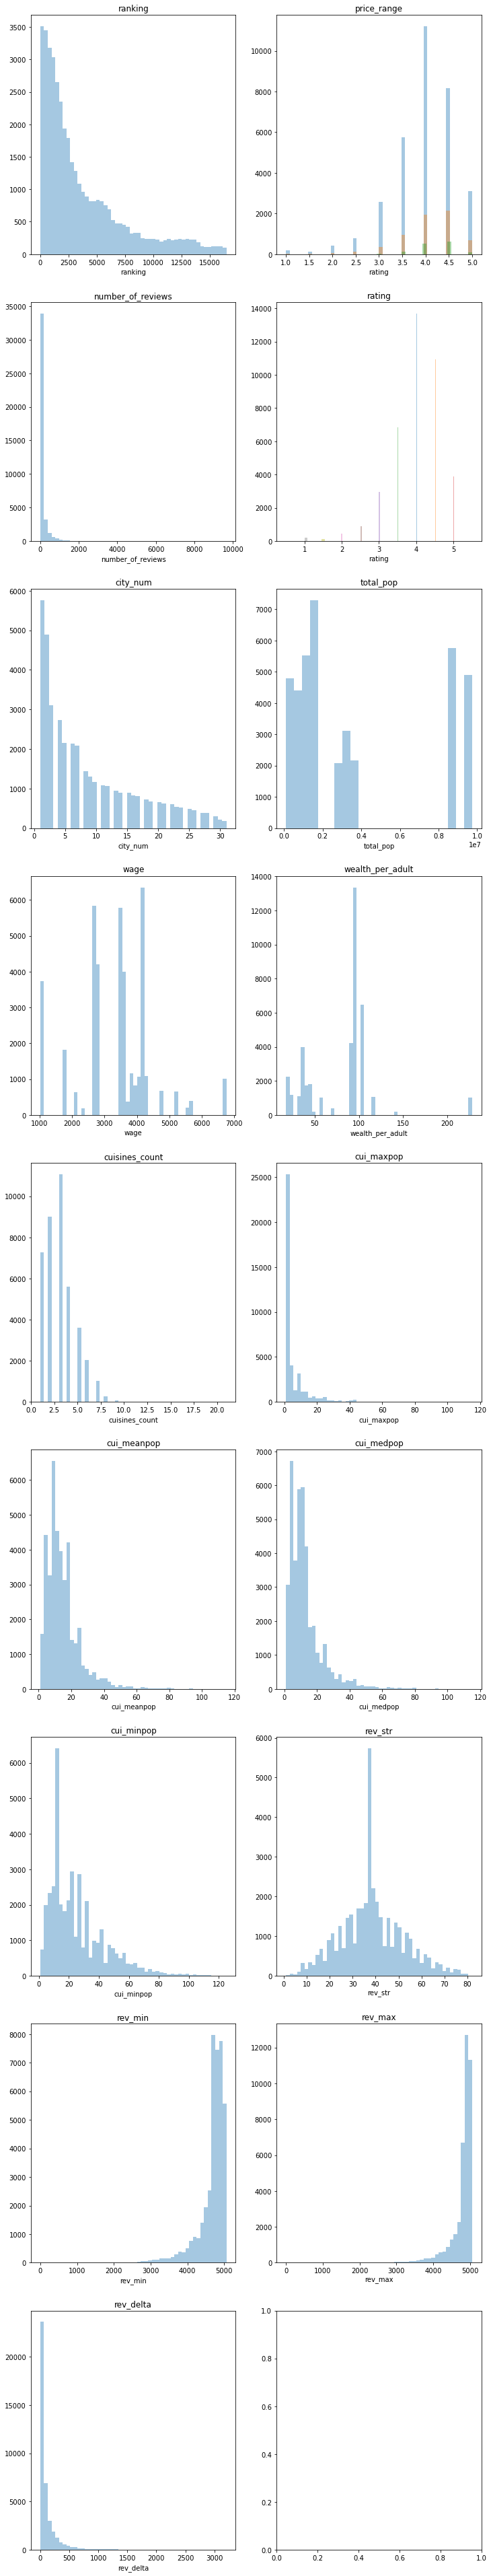

In [21]:
firstlook(df_filtered)

In [22]:
# Виртуальный датафрейм "score по критериям столбца"
def corrcol(df, col):
    # достаём качества из столбца
    names = pd.DataFrame(df[col].value_counts()).index.tolist()
    # создаем буферный список
    predata = []
    for name in names:  # перелистываем качества
        # создаём список значений score по качеству из основного датафрейма
        name = pd.DataFrame(df['rating'][df[col] == name])['rating'].tolist()
        # аппендим список значений в буферный список и получаем двухуровневый список
        predata.append(name)
    # транспонируем
    col = pd.DataFrame(predata).T
    # переименовываем столбцы
    col.columns = names
    return col  # возвращаем датафрейм


# Очиститель по качественности
def cleanqua(df):
    stcol = df.columns.tolist()  # список столбцов
    for colu in stcol:  # перебираем столбцы датафрейма
        # создаём список качеств внутри столбца
        names = pd.DataFrame(df[colu].value_counts()).index.tolist()
        # если количество качеств больше 10
        if len(names) > 10:
            # то удаляем столбец из списка
            stcol.remove(colu)
    return stcol


# Построитель heatmap по всему датафрейму
def heatmaps(df):
    stcol = df.columns.tolist()  # список столбцов
    columns = 2  # удобное число столбцов
    rows = m.ceil(len(stcol)/columns)  # расчитываем число строк
    cou = 0  # счётчик для графиков

    # создаём поле с сабплотами
    fig, axes = plt.subplots(rows, columns, figsize=(12, rows*1.2))
    plt.subplots_adjust(top=4)

    for col in stcol:  # снова перебираем столбцы датафрейма
        # создаём список качеств внутри столбца
        names = pd.DataFrame(df[col].value_counts()).index.tolist()
        sns.heatmap(pd.DataFrame(corrcol(df, col).describe()).loc['mean':], annot=False,
                    cmap="viridis", ax=axes[cou // columns][cou % columns])
        # применяем название к сабплоту
        axes[cou // columns][cou % columns].set_title(col)
        # наращиваем счётчик сабплота
        cou += 1
    return

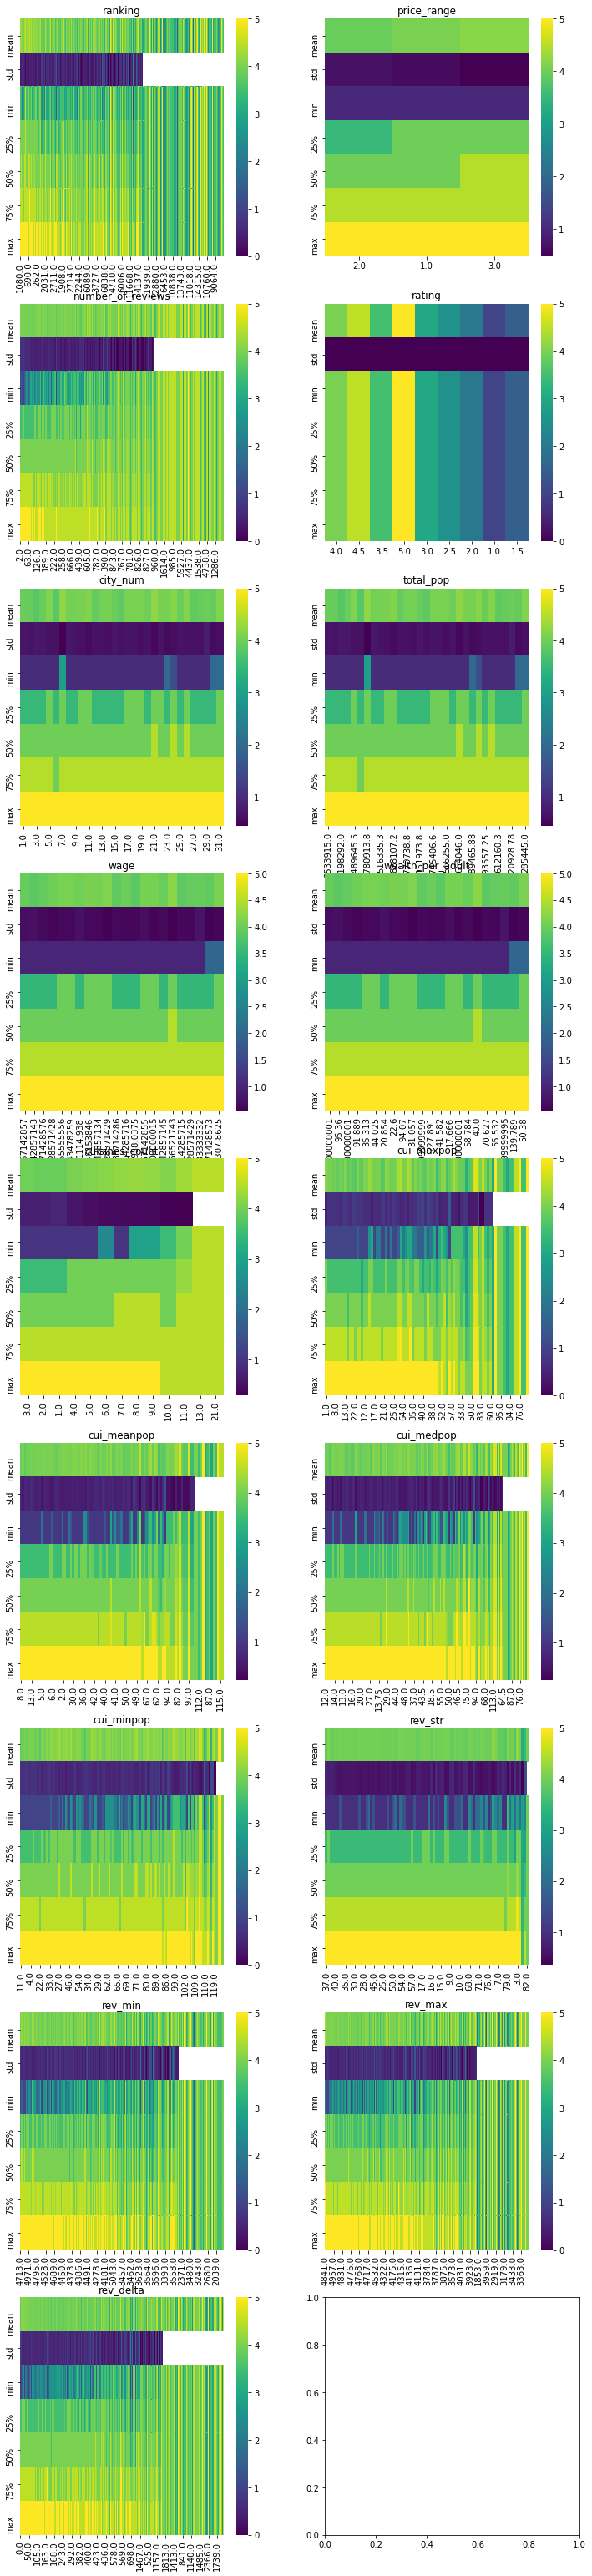

In [23]:
heatmaps(df_filtered)

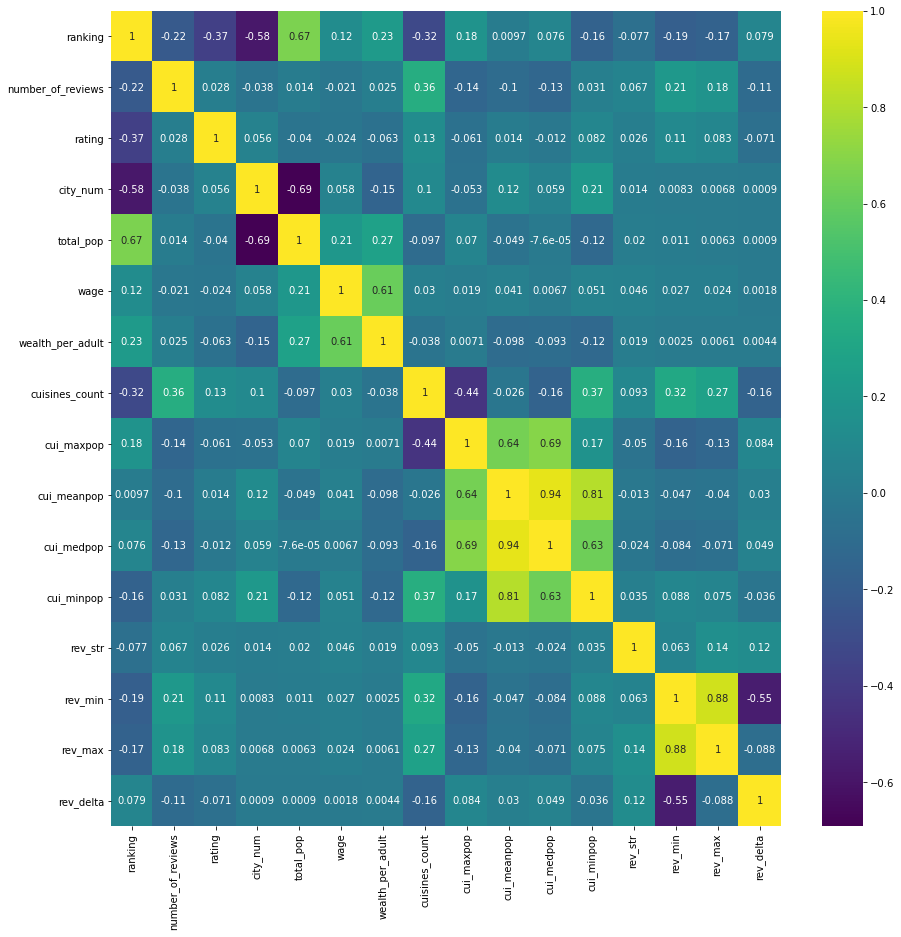

In [24]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_filtered.drop('price_range', axis=1).corr(), annot=True, cmap="viridis", ax=ax)

Итого по большому счёту я показал сейчас кучу цветастых и не очень полезных картинок :)
Исключение, последний хитмап, но и то есть вопросы если сравнивать с финальным графиком "важности для модели".

# Data Preprocessing

In [25]:
df_preproc = df.copy()
df_preproc.sample(10)

,ranking,price_range,number_of_reviews,sample,rating,city_num,total_pop,wage,wealth_per_adult,cuisines_count,...,Caucasian,Azerbaijani,Welsh,Fujian,Polynesian,Yunnan,Burmese,Salvadoran,Xinjiang,Latvian
34770,7280.0,1.0,24.0,1,3.0,4.0,1615264.40,2670.744643,95.360,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39328,567.0,2.0,50.0,1,3.5,25.0,193557.25,6756.523214,227.891,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45810,8503.0,2.0,16.0,1,4.0,2.0,9735003.00,3462.405357,101.942,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3597,5126.0,2.0,7.0,0,0.0,3.0,3198292.00,2670.744643,95.360,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43278,493.0,2.0,31.0,1,4.5,21.0,664046.00,2146.808696,40.000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45353,202.0,2.0,266.0,1,4.5,17.0,1745406.60,1021.239286,17.666,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3101,829.0,2.0,306.0,0,0.0,21.0,664046.00,2146.808696,40.000,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,355.0,2.0,330.0,0,0.0,1.0,8533915.00,4153.392857,97.452,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34895,5621.0,2.0,14.0,1,3.5,3.0,3198292.00,2670.744643,95.360,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18248,5893.0,2.0,154.0,1,3.5,2.0,9735003.00,3462.405357,101.942,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

In [27]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [28]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 187), (40000, 187), (40000, 186), (32000, 186), (8000, 186))

# Model 
Сам ML

In [29]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [30]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [31]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [32]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2068775


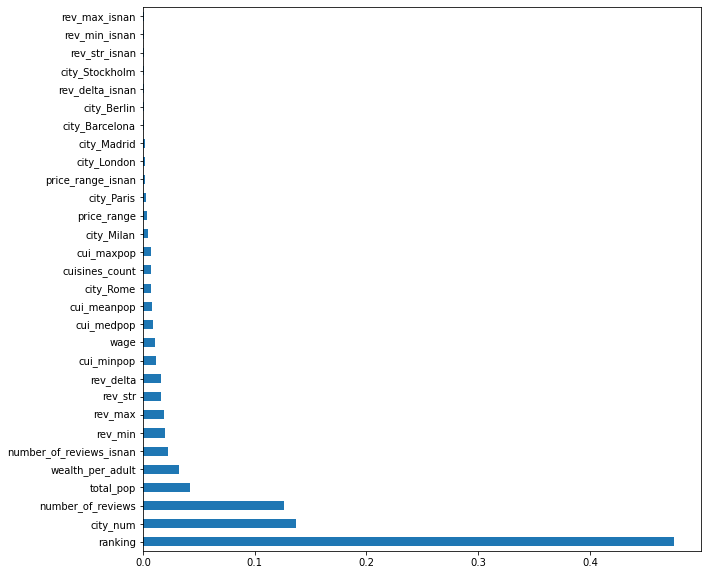

In [33]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

# Выводы

1. Забывать про разведку совершенно недопустимо. Потому что отсутсвие прироста качества обучения от добавления признаков скорее всего связано с их взаимной корреляцией, а следовательно их избыточностью.
1. Действовал я совершенно непоследовательно. Перепрыгивая с куска на кусок с этапа на этап. Ни производительности, ни качества это не прибавило.
1. Уделив слишком много внимания различным скриптам я не смог уделить достаточно внимания поиску доп признаков и вычёсыванию тех что были.
1. Изобретение костыльных велосипедов отняло кучу времени. Это, конечно, очень интересно, а местами и полезно, но лучше было бы поискать готовые решения и намотать их на ус.